In [56]:
import baltic as bt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
import time
#import pymc3
import math
import arviz as az
#from hpd import hpd
import scipy.stats as stats
from io import StringIO
import altair as alt
from altair import datum
alt.data_transformers.disable_max_rows()

from zipfile import ZipFile


import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp


%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap


from scipy.special import binom

In [13]:
log_file_path = "/Users/mparedes/Desktop/254_mascot_glm_unmasked_region.log"


In [14]:
burnin_percent = 0.1

In [17]:
def read_in_Ne_changes_mascot(log_file_path):
    
    Ne_skyline_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        line_number = 0
        for line in infile:
            line_number += 1
            if not line.startswith("#"):  # log combiner will sometimes put the entire xml at the start of the log file
                # use the first line to find the migration rate columns
                #print(line)
            # use the first line to find the migration rate columns
                if "posterior" in line:
                    all_cols = line.split("\t")
                    Ne_column_indices = []   # list to store column indices
                    Nes_key = {}   # dictionary to store the column index to map to column name

                    for i in range(len(all_cols)):
                        col = all_cols[i]
                        if "Ne." in col:
                            Ne_column_indices.append(i)

                    # make an empty dictionary to store Nes and generate dictionary to convert index to name
                    for n in Ne_column_indices:
                        name = line.split("\t")[n]
                        deme = name.split(".")[1]# the syntax here is "Ne.region.1" where region is deme and 1 is interval 1
                        interval = name.split(".")[2]
                       
                        Nes_key[n] = name
                        Ne_skyline_dict[name] = []


                # read in actual parameter estimates and store in dictionary
                else:
                    sample = line.split("\t")[0]
                    Ne_skyline_dict["sample"].append(sample)

                    for index in Ne_column_indices:
                        name = Nes_key[index]
                        Ne_skyline_dict[name].append(line.split("\t")[index])
                    
                
    return(Ne_skyline_dict)

In [18]:
Ne_skyline = read_in_Ne_changes_mascot(log_file_path)

In [19]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        if "Ne" in i:
            deme = i.split(".")[1]
            #print(deme)
            interval = i.split(".")[2]
            #print(interval)
            #print(i)
            next_interval = int(interval)+1
            local_series = input_df[i].astype('float').to_numpy()
            #print(local_series)
            mean_log = local_series.mean()
            mean_linear = 10**mean_log
            hpd_95 = az.hdi(local_series, 0.95)
            lower_hpd_log_95 = hpd_95[0]
            lower_hpd_linear_95 = 10**lower_hpd_log_95
            upper_hpd_log_95 = hpd_95[1]
            upper_hpd_linear_95 = 10**upper_hpd_log_95
            hpd_50 = az.hdi(local_series, 0.50)
            lower_hpd_log_50 = hpd_50[0]
            lower_hpd_linear_50 = 10**lower_hpd_log_50
            upper_hpd_log_50 = hpd_50[1]
            upper_hpd_linear_50 = 10**upper_hpd_log_50
            
            try:
                next_local_series = input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float').to_numpy()
                diff_series = np.subtract(local_series, next_local_series)
                #print(local_series)
                #print(next_local_series)
                #print(diff_series)
                diff_mean_log = diff_series.mean()
                diff_hpd_95 = az.hdi(diff_series, 0.95)
                diff_lower_hpd_log_95 = diff_hpd_95[0]
                diff_lower_hpd_linear_95 = math.exp(diff_lower_hpd_log_95)
                diff_upper_hpd_log_95 = diff_hpd_95[1]
                diff_upper_hpd_linear_95 = math.exp(diff_upper_hpd_log_95)
                diff_hpd_50 = az.hdi(diff_series, 0.50)
                diff_lower_hpd_log_50 = diff_hpd_50[0]
                diff_lower_hpd_linear_50 = math.exp(diff_lower_hpd_log_50)
                diff_upper_hpd_log_50 = diff_hpd_50[1]
                diff_upper_hpd_linear_50 = math.exp(diff_upper_hpd_log_50)
            except KeyError:
                pass   
            
            try:
                local_df = pd.DataFrame.from_dict({"deme":deme, "interval":interval, "mean_Ne_log":mean_log,"mean_Ne_linear":mean_linear, 
                                                   "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                   "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50,
                                                   "upper_hpd_linear":upper_hpd_linear_95,"lower_hpd_linear":lower_hpd_linear_95,
                                                   "diff_mean_Ne_log":diff_mean_log, 
                                                   "diff_upper_hpd_log_95":diff_upper_hpd_log_95,"diff_lower_hpd_log_95":diff_lower_hpd_log_95, 
                                                   "diff_upper_hpd_log_50":diff_upper_hpd_log_50,"diff_lower_hpd_log_50":diff_lower_hpd_log_50,
                                                   "diff_upper_hpd_linear":diff_upper_hpd_linear_95,"diff_lower_hpd_linear":diff_lower_hpd_linear_95,
                                                   "diff_upper_hpd_linear_50":diff_upper_hpd_linear_50,"diff_lower_hpd_linear_50":diff_lower_hpd_linear_50})
                new_df = new_df.append(local_df)
                #print(new_df)
            except:
                pass
            
    return(new_df)

In [20]:
Ne_df = pd.DataFrame.from_dict(Ne_skyline)
print(len(Ne_df))


8345


In [21]:
ne_summary = generate_summary_df(Ne_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_52609/2123161553.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

In [23]:
ne_summary

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,upper_hpd_linear,lower_hpd_linear,diff_mean_Ne_log,diff_upper_hpd_log_95,diff_lower_hpd_log_95,diff_upper_hpd_log_50,diff_lower_hpd_log_50,diff_upper_hpd_linear,diff_lower_hpd_linear,diff_upper_hpd_linear_50,diff_lower_hpd_linear_50
0,CentralEurope,0,0.05313,1.130134,0.119992,0.002594,0.038612,0.004410,1.318233,1.005990,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,CentralEurope,1,0.05313,1.130134,0.119992,0.002594,0.038612,0.004410,1.318233,1.005990,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,CentralEurope,2,0.05313,1.130134,0.119992,0.002594,0.038612,0.004410,1.318233,1.005990,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,CentralEurope,3,0.05313,1.130134,0.119992,0.002594,0.038612,0.004410,1.318233,1.005990,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,CentralEurope,4,0.05313,1.130134,0.119992,0.002594,0.038612,0.004410,1.318233,1.005990,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,WesternEurope,226,0.32279,2.102760,0.545083,0.074827,0.302256,0.105562,3.508186,1.188029,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,WesternEurope,227,0.32279,2.102760,0.545083,0.074827,0.302256,0.105562,3.508186,1.188029,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,WesternEurope,228,0.32279,2.102760,0.545083,0.074827,0.302256,0.105562,3.508186,1.188029,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,WesternEurope,229,0.32279,2.102760,0.545083,0.074827,0.302256,0.105562,3.508186,1.188029,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [25]:
test = ne_summary
test['days'] = test.interval.astype(int) 
test['date'] = dt.strptime("2022-11-30",  "%Y-%m-%d") - test.days.map(timedelta)
#test.date = test.date.astype(str)

In [44]:
domain = ['CentralEurope', 'NorthAmerica', 'SouthAmerica' ,"SouthernEurope", "WesternEurope"]
range_ = ['#EEC060', '#2664A5', '#A76BB1', "#EEA160", "#356D4C"]

In [45]:
line = alt.Chart(test).mark_area(interpolate='monotone').encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False, format="%B %Y")),
    alt.Y('lower_hpd_log_50',axis=alt.Axis(title="Effective Population Size", grid=False)),#,scale=alt.Scale(domain=(0, 13))),
    alt.Y2('upper_hpd_log_50' ),
    color=alt.Color('deme:N',  scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=850,
    height=400
)#.transform_filter(
  #  (datum.upper_hpd_log_50 < 50)
#)

band = alt.Chart(test).mark_area(
    opacity=0.3, interpolate='monotone'
).encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False)),
    alt.Y('lower_hpd_log_95'),#axis=None),#, scale=alt.Scale(domain=(0, 13))),
    alt.Y2('upper_hpd_log_95'),
    color=alt.Color('deme:N')
).properties(
    width=850,
    height=400
)#.transform_filter(
 #   (datum.upper_hpd_log_95 < 50)
#)

line + band

alt.LayerChart(...)

## plot regional tree reconstruction from mascot glm mcc tree

In [60]:
def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.strftime(dt.strptime(x,start),end)

In [46]:
# set path to tree to load 
tree_path = "/Users/mparedes/Desktop/mcc_mpox/254_glm_region_mcc.tree"

In [47]:
# load trees
tree = bt.loadNexus(tree_path, tip_regex='_([0-9\-]+)$')
tree.setAbsoluteTime(2022.9137)

In [50]:
all_geos = []

for k in tree.Objects: 
    if k.branchType=='node':
        #print(k.traits)
        division = k.traits['max']
        all_geos.append(division)
print(set(all_geos))

{'SouthernEurope', 'NorthAmerica', 'CentralEurope', 'WesternEurope', 'SouthAmerica'}


In [53]:
# add together probabilities for divisions in the same regions

# parse leaf and node information into a dictionary for plotting
metadata = {}
node_types = {}
node_probs = {}

for k in tree.Objects: ## iterate over objects in tree
    if k.branchType=='leaf':
        division = k.traits['max']
        #region = regions[division]
        metadata[k] = {}
        metadata[k]["division"] = division
        #metadata[k]["region"] = region
        node_probs[k] = k.traits["max.prob"]  # for a leaf, this is always 1.0
    
    # parse the nodes now and pick out the type trait
    if k.branchType=='node':
        node_division = k.traits["max"]
        division_prob = k.traits["max.prob"]
        
        #node_region = regions[node_division]       
        geo_set = k.traits['max.set']
        geo_set_prob = k.traits['max.set.prob']
        
        node_prob = 0
        for i in range(len(geo_set)):
            division = geo_set[i]
            #region = regions[division]
            geo_prob = geo_set_prob[i]
            
            #if region == node_region:
            node_prob += geo_prob
        
        
        node_types[k] = {}
        node_types[k]["division"] = node_division
        #node_types[k]["region"] = node_region 
        node_probs[k] = division_prob
        #division_probs[k] = division_prob
        #print(node_probs[k])

In [72]:


#region = {('Canada','USA'):'North America',
#          'Finland':'Northern Europe',
#          ('Austria','Germany','Switzerland','UnitedKingdom','France','Belgium','Netherlands'):'Western Europe', 
#          ('Slovakia','Slovenia'):'Central/Eastern Europe',
#          ('Italy','Portugal','Spain'):'Southern Europe',
#          ('Colombia','Peru'):'South America'}



colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
         }

uncertainty_color = "#B9B9B9"

division_order = [ 'NorthAmerica', "WesternEurope", 'CentralEurope', "SouthernEurope", 'SouthAmerica' ]

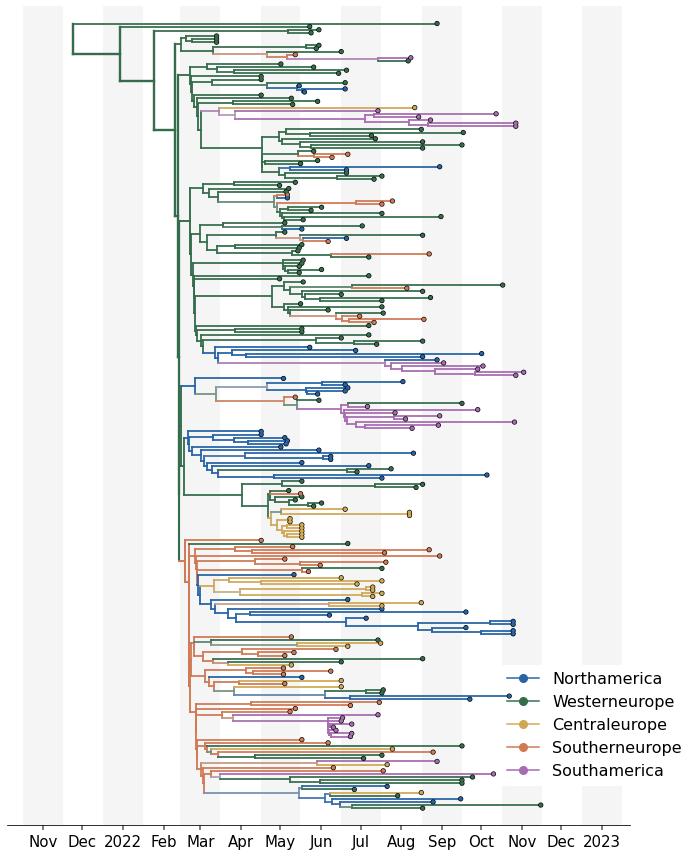

In [74]:
fig,ax = plt.subplots(figsize=(10,12),facecolor='w')



branchWidth=1.75 ## default branch width
tipSize = 15

# k objects are tips, nodes, branches
for k in tree.Objects: ## iterate over objects in tree
    x=k.absoluteTime ## or use absolute time instead
    y=k.y 
    
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        base_color=colors[metadata[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color,base_color], N=256)
        c = color_ramp(node_probs[k])
        s=tipSize
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        base_color=colors[node_types[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color, base_color], N=256)
        c = color_ramp(node_probs[k])
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        
    ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)
        
    # add in a legend
    han_list = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in division_order:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
    han_list.append(marker)

xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]

every=1
[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=16,size=0)    
    
# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.set_ylim(-5,tree.ySpan+5)
ax.set_xlim(2021.8,2023.1)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=15,size=5, width=2,color='grey')
   # set date labels every 4
ax.set_yticklabels([])

# in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.78, 0.04], loc=3,prop={'size': 16}, facecolor='w')

fig.tight_layout()
plt.gcf().subplots_adjust(right=0.88)
plt.savefig('../figures/mcc_glm_region_300.png',dpi=300,bbox_inches='tight')

plt.show()